In [ ]:
!pip install easydict

In [ ]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#glob模块主要用于查找符合特定规则的文件路径名，类似使用windows下的文件搜索
import glob
#os模块主要用于处理文件和目录
import os
 
import numpy as np
import matplotlib.pyplot as plt
 
import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
import mindspore.dataset.vision.c_transforms as CV
#c_transforms模块提供常用操作，包括OneHotOp和TypeCast
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import context
#导入模块用于初始化截断正态分布
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

#定义变量
cfg = edict({
    'data_path': 'flower_photos',
    'data_size':3670,
    'image_width': 100,  # 图片宽度
    'image_height': 100,  # 图片高度
    'batch_size': 32,
    'channel': 3,  # 图片通道数
    'num_class':5,  # 分类类别
    'weight_decay': 0.01,
    'lr':0.0001,  # 学习率
    'dropout_ratio': 0.5,
    'epoch_size': 400,  # 训练次数
    'sigma':0.01,
    
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 1,  # 最多保存多少个模型
    'output_directory': './',  # 保存模型路径
    'output_prefix': "checkpoint_classification"  # 保存模型文件名字
})


In [ ]:
# 解压数据集，只需要第一次运行时解压，第二次无需再解压
#!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos.zip 
!unzip flower_photos.zip 

In [3]:
#读取图像的源数据集。
de_dataset = ds.ImageFolderDataset(cfg.data_path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
#解码前将输入图像裁剪成任意大小和宽高比。
transform_img = CV.RandomCropDecodeResize([cfg.image_width,cfg.image_height], scale=(0.08, 1.0), ratio=(0.75, 1.333))  #改变尺寸
#转换输入图像；形状（H, W, C）为形状（C, H, W）。
hwc2chw_op = CV.HWC2CHW()
#转换为给定MindSpore数据类型的Tensor操作。
type_cast_op = C.TypeCast(mstype.float32)
#将操作中的每个操作应用到此数据集。
de_dataset = de_dataset.map(input_columns="image", num_parallel_workers=8, operations=transform_img)
de_dataset = de_dataset.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=8)
de_dataset = de_dataset.map(input_columns="image", operations=type_cast_op, num_parallel_workers=8)
de_dataset = de_dataset.shuffle(buffer_size=cfg.data_size)

[WARNING] ME(803:281472913131392,MainProcess):2022-11-22-09:06:19.474.041 [mindspore/dataset/engine/datasets.py:1122] Dataset is shuffled before split.


训练数据集数量： 2912
测试数据集数量： 704
通道数/图像长/宽： (3, 100, 100)
一张图像的标签样式： 1


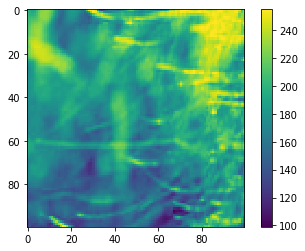

In [4]:
#划分训练集测试集
(de_train,de_test)=de_dataset.split([0.8,0.2])
#设置每个批处理的行数
#drop_remainder确定是否删除最后一个可能不完整的批（default=False）。
#如果为True，并且如果可用于生成最后一个批的batch_size行小于batch_size行，则这些行将被删除，并且不会传播到子节点。
de_train=de_train.batch(cfg.batch_size, drop_remainder=True)
#重复此数据集计数次数。
de_test=de_test.batch(cfg.batch_size, drop_remainder=True)
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size()*cfg.batch_size)
 
data_next=de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'].shape)
print('一张图像的标签样式：', data_next['label'])  # 一共5类，用0-4的数字表达类别。
 
plt.figure()
plt.imshow(data_next['image'][0,...])
plt.colorbar()
plt.grid(False)
plt.show()


In [6]:
# 定义CNN图像识别网络
class Identification_Net(nn.Cell):
    def __init__(self, num_class=5,channel=3,dropout_ratio=0.5,trun_sigma=0.01):  # 一共分五类，图片通道数是3
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel
        self.dropout_ratio = dropout_ratio
        #设置卷积层
        self.conv1 = nn.Conv2d(self.channel, 32,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        #设置ReLU激活函数
        self.relu = nn.ReLU()
        #设置最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2,pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv3 = nn.Conv2d(64, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv4 = nn.Conv2d(128, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma), bias_init='zeros')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(6*6*128, 1024,weight_init =TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.dropout = nn.Dropout(self.dropout_ratio)
        self.fc2 = nn.Dense(1024, 512, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
    #构建模型
    def construct(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.max_pool2d(x)
        x = self.conv4(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [7]:
net=Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)
#计算softmax交叉熵。
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#opt
fc_weight_params = list(filter(lambda x: 'fc' in x.name and 'weight' in x.name, net.trainable_params()))
other_params=list(filter(lambda x: 'fc' not in x.name or 'weight' not in x.name, net.trainable_params()))
group_params = [{'params': fc_weight_params, 'weight_decay': cfg.weight_decay},
                {'params': other_params},
                {'order_params': net.trainable_params()}]
#设置Adam优化器
net_opt = nn.Adam(group_params, learning_rate=cfg.lr, weight_decay=0.0)
#net_opt = nn.Adam(params=net.trainable_params(), learning_rate=cfg.lr, weight_decay=0.1)
 
model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
loss_cb = LossMonitor(per_print_times=de_train.get_dataset_size()*10)
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)
print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)
 
# 使用测试集评估模型，打印总体准确率
metric = model.eval(de_test)
print(metric)


============== Starting Training ==============


[WARNING] DEVICE(803,ffff85004780,python):2022-11-22-09:06:56.253.105 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[DropoutGenMask] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(803,ffff85004780,python):2022-11-22-09:06:56.257.375 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[DropoutGenMask] don't support int64, reduce precision from int64 to int32.


epoch: 10 step: 91, loss is 1.168920874595642
epoch: 20 step: 91, loss is 1.0515644550323486
epoch: 30 step: 91, loss is 0.9127898216247559
epoch: 40 step: 91, loss is 0.8017018437385559
epoch: 50 step: 91, loss is 0.8668797016143799
epoch: 60 step: 91, loss is 0.5199137330055237
epoch: 70 step: 91, loss is 0.4118347465991974
epoch: 80 step: 91, loss is 0.9584700465202332
epoch: 90 step: 91, loss is 0.454145610332489
epoch: 100 step: 91, loss is 0.48285573720932007
epoch: 110 step: 91, loss is 0.5599947571754456
epoch: 120 step: 91, loss is 0.37438657879829407
epoch: 130 step: 91, loss is 0.5332098007202148
epoch: 140 step: 91, loss is 0.5198065042495728
epoch: 150 step: 91, loss is 0.27863577008247375
epoch: 160 step: 91, loss is 0.3225116431713104
epoch: 170 step: 91, loss is 0.3911120295524597
epoch: 180 step: 91, loss is 0.33511844277381897
epoch: 190 step: 91, loss is 0.5524019002914429
epoch: 200 step: 91, loss is 0.3239593803882599
epoch: 210 step: 91, loss is 0.4299424886703491

第1张图像的真实标签为： 3


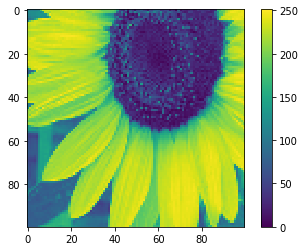

第1个sample预测标签为： 3 输出结果为： sunflowers
第2张图像的真实标签为： 2


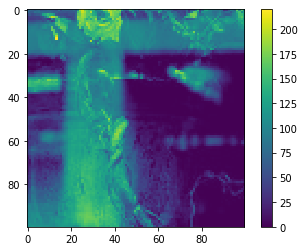

第2个sample预测标签为： 1 输出结果为： dandelion
第3张图像的真实标签为： 2


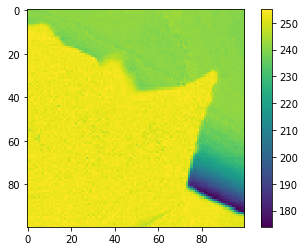

第3个sample预测标签为： 2 输出结果为： roses
第4张图像的真实标签为： 1


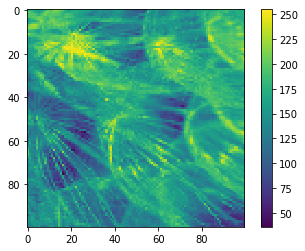

第4个sample预测标签为： 1 输出结果为： dandelion
第5张图像的真实标签为： 2


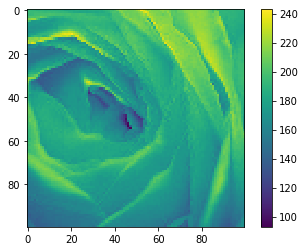

第5个sample预测标签为： 2 输出结果为： roses


In [8]:
import os
CKPT = os.path.join(cfg.output_directory,cfg.output_prefix+'-'+str(cfg.epoch_size)+'_'+str(de_train.get_dataset_size())+'.ckpt')
net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)
load_checkpoint(CKPT, net=net)
model = Model(net)

# 预测
#class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
#test_ = de_test.create_dict_iterator().__next__()
#test = Tensor(test_['image'], mindspore.float32)
#predictions = model.predict(test)
#predictions = predictions.asnumpy()
#true_label = test_['label'].asnumpy()
 
#预测
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}

for i in range(5):
    data_next=de_dataset.create_dict_iterator(output_numpy=True).__next__()
    print('第'+str(i+1)+'张图像的真实标签为：', data_next['label'])  # 一共5类，用0-4的数字表达类别。
    plt.figure()
    plt.imshow(data_next['image'][0,...])
    plt.colorbar()
    plt.grid(False)
    plt.show()

    test = Tensor(data_next['image'], mindspore.float32)
    test=test.reshape(1,3,100,100)
    predictions = model.predict(test)
    predictions = predictions.asnumpy()

#显示预测结果
#for i in range(10):
#    p_np = predictions[i, :]
#    pre_label = np.argmax(p_np)
#    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[i]])

 #显示预测结果
    p_np = predictions
    pre_label = np.argmax(p_np)
    print('第' + str(i+1) + '个sample预测标签为：',pre_label,'输出结果为：', class_names[pre_label])   